# DCEM for Mountain Car

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [2]:
import random
import os
import gc
import typing as tp
import numpy as np
import torch


NUM_THREADS = 10
SEED = 123


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def _init_fn(worker_id):
    np.random.seed(SEED + worker_id)

def preset():
    seed_everything(SEED)
    torch.cuda.empty_cache()
    gc.collect()
    
seed_everything(SEED)

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

In [25]:
from IPython.display import clear_output
from multiprocessing import Pool
from functools import partial
from copy import deepcopy


class DeepCEM:
    def __init__(
        self,
        env_name,
        *,
        learning_rate_init=1e-3, 
        learning_iter_per_fit=16,
    ):
        self.env_name = env_name
        self.env = self.reset_env()
        self.n_actions = self.env.action_space.n
        self.states_dim = self.env.observation_space.shape
        
        self.learning_rate_init = learning_rate_init
        self.learning_iter_per_fit = learning_iter_per_fit
        
        self.log = []
    
    def reset_env(self):
        return gym.make(self.env_name).env
        
    def initialize_policy(self):
        self.policy = nn.Sequential(
            nn.Linear(self.states_dim[0], 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, self.n_actions),
        )
        
        self.optimizer = torch.optim.Adam(
            self.policy.parameters(),
            lr=self.learning_rate_init
        )
        
        self.loss = nn.CrossEntropyLoss()
        
    def get_action(self, state):
        with torch.no_grad():
            logits = self.policy(torch.FloatTensor(state))
        
        action_probs = F.softmax(logits, dim=-1).numpy()
        
        return np.random.choice(self.n_actions, p=action_probs)
            
    def generate_sessions(self, n_sessions, multiprocess=None, t_max=10**4, cpu_count=30):       
        if multiprocess == 'pool':
             with Pool(cpu_count) as pool:
                return pool.map(
                    partial(self.generate_session, reset=True, t_max=t_max),
                    range(n_sessions),
                )
        
        return [self.generate_session(i, t_max=t_max) for i in range(n_sessions)]
    
    def generate_session(self, i, reset=False, t_max=10**4):
        env = self.reset_env() if reset else self.env
            
        states, actions = [], []
        total_reward = total_discount_reward = 0.

        s = env.reset()

        for t in range(t_max):
            a = self.get_action(s)

            new_s, r, done, info = env.step(a)

            states.append(s)
            actions.append(a)
            total_reward += r

            s = new_s
            if done:
                break

        return states, actions, total_reward
    
    def select_elites(self, states_batch, actions_batch, rewards_batch, percentile):  
        reward_threshold = np.percentile(rewards_batch, percentile)

        elite_states = []
        elite_actions = []
        for states, actions, reward in zip(states_batch, actions_batch, rewards_batch):
            if reward > reward_threshold:
                elite_states.extend(states)
                elite_actions.extend(actions)

        return elite_states, elite_actions
    
    def get_new_policy(self, elite_states, elite_actions, learning_rate):
        if not elite_states:
            return self.policy
        
        elite_states = torch.FloatTensor(elite_states)
        elite_actions = torch.LongTensor(elite_actions)
        
        for _ in range(self.learning_iter_per_fit):
            logits = self.policy(elite_states)
            loss = self.loss(logits, elite_actions)
            self.optimizer.zero_grad()
            old_policy = deepcopy(self.policy)
            loss.backward()
            self.optimizer.step()

            for new_parameter, old_parameter in zip(self.policy.parameters(), old_policy.parameters()):
                new_parameter.data.copy_(
                    learning_rate * new_parameter + (1 - learning_rate) * old_parameter,
                )
            
        return self.policy
    
    def show_progress(self, rewards_batch, percentile, reward_range):
        mean_reward = np.mean(rewards_batch)
        threshold = np.percentile(rewards_batch, percentile)
        self.log.append([mean_reward, threshold])

        clear_output(True)
        print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
        plt.figure(figsize=[8, 4])
        plt.subplot(1, 2, 1)
        plt.plot(list(zip(*self.log))[0], label='Mean rewards')
        plt.plot(list(zip(*self.log))[1], label='Reward thresholds')
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.hist(rewards_batch, range=reward_range)
        plt.vlines([np.percentile(rewards_batch, percentile)],
                   [0], [100], label="percentile", color='red')
        plt.legend()
        plt.grid()

        plt.show()
    
    def train(
        self,
        *, 
        n_epochs, 
        n_sessions, 
        percentile,
        learning_rate=0.5,
        win_threshold=None,
        t_max=10**4,
        multiprocess=None,
        cpu_count=30,
    ):
        self.initialize_policy()
        self.log = []
        
        for i in range(n_epochs):
            sessions = self.generate_sessions(
                n_sessions, 
                t_max=t_max,
                multiprocess=multiprocess,
                cpu_count=cpu_count,
            )

            states_batch, actions_batch, rewards_batch = zip(*sessions)

            elite_states, elite_actions = self.select_elites(
                states_batch,
                actions_batch, 
                rewards_batch,
                percentile,
            )

            self.policy = self.get_new_policy(elite_states, elite_actions, learning_rate)

            self.show_progress(
                rewards_batch, 
                percentile, 
                reward_range=[np.min(rewards_batch), np.max(rewards_batch)],
            )
            
            if win_threshold and np.mean(rewards_batch) > win_threshold:
                print("You Win!")
                return

mean reward = 550.537, threshold=825.600


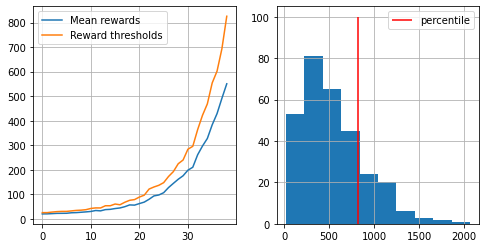

You Win!


In [27]:
preset()
trainer = DeepCEM('CartPole-v0')
trainer.train(
    n_epochs=500,
    n_sessions=300,
    percentile=80,
    win_threshold=500,
    multiprocess='pool',
    cpu_count=2,
)

mean reward = -145.700, threshold=-144.500


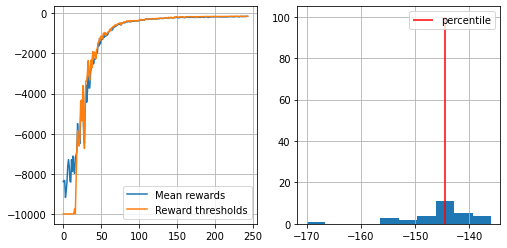

You Win!


In [29]:
preset()
trainer = DeepCEM('MountainCar-v0')
trainer.train(
    n_epochs=500,
    n_sessions=30,
    percentile=50,
    win_threshold=-150,
    multiprocess='pool',
    cpu_count=2,
)